# Reproduction of Paper `Learning the Graphical Structure of Electronic Health Records with Graph Convolutional Transformer` by DL4H Team 137

## Introduction


*   Background of the problem
    * This study focuses on readmission/mortality prediction.
    * Unstructured data, particularly claims data, lacks a clear structure, making it challenging for models like MiME (Choi et al., 2018) to be utilized effectively.
    * The primary difficulties include discovering the hidden structure of the data while simultaneously making predictions.

    * The approach outlined in the paper is effective according to their test metrics.
*   Paper explanation
    * The paper proposes a new method, the Graph Convolutional Transformer (GCT), to jointly learn the hidden structure and perform the prediction task. This method uses unstructured data as the initial input and achieves accurate predictions for general medical tasks.
    * It offers significant benefits for individuals without access to structured data. Additionally, the learned structure can be useful for others who wish to reuse the learned structure for future studies.



#

# Scope of reproducibility (5)
The scope of this reproducibility study focuses on verifying the results claimed in the paper "Learning the Graphical Structure of Electronic Health Records with Graph Convolutional Transformer". The goal is to reproduce the model's ability to predict readmission/mortality using electronic health records as described in the original research.

# Methodology (15)

## Environment
### Python version
- Python 3.10
### Dependencies/packages needed
- torch==1.7.1
- numpy==1.19.5
- pandas==1.2.0
- scikit-learn==0.24.1
- matplotlib==3.3.3

## Data
### Data download instruction
- The eICU data comes from https://physionet.org/content/eicu-crd/2.0/.
- You are required to participate in the CITI training.
- Download the patient, admissionDx, diagnosis, treatment CSV files
- Decompress and upload to your environment.
### Data descriptions with helpful charts and visualizations
- Admission Diagnosis without Encounter ID: 450589
- Diagnosis without Encounter ID: 2483092
- Treatment without Encounter ID: 3372000
- Accepted treatments: 316745
- Total eicu as input: 40410
### Preprocessing code
- shown below

#### load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#load data
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
filenames = ['patient', 'admissionDx', 'diagnosis', 'treatment']
#raw_data_dir='./'
print("change 'raw_data_dir' if you are using different environment")
raw_data_dir = '/content/drive/My Drive/Colab_Notebooks/'
SUBSET_RATIO=1

def load_raw_data(raw_data_dir, filenames, subset_ratio=SUBSET_RATIO):

    data_frames = {}
    for filename in filenames:
        file_path = raw_data_dir + filename +'.csv'
        df = pd.read_csv(file_path)

        if subset_ratio < 1.0:
            df = df.sample(frac=subset_ratio)
        data_frames[filename]=df
    return data_frames
data_frames = load_raw_data(raw_data_dir, filenames)

change 'raw_data_dir' if you are using different environment


#### Preprocess data and generate the eicu record

In [4]:
import sys
# preprocess patient data
def process_patient(df, hour_threshold=24):
    # Calculate encounter_timestamp and create a temporary DataFrame for sorting
    if df['patientunitstayid'].duplicated().any():
        print('Duplicate encounter ID!!')
        sys.exit(0)
    df['encounter_timestamp'] = -df['hospitaladmitoffset'].astype(int)

    # Sorting patients by their IDs and then by the encounter timestamp
    df_sorted = df.sort_values(['patienthealthsystemstayid', 'encounter_timestamp'])

    # Detect readmissions by checking if the next stay is within the same patient ID

    df_sorted['readmission'] = True  # Initially mark all as True
    df_sorted.loc[df_sorted.groupby('patienthealthsystemstayid')['patientunitstayid'].tail(1).index, 'readmission'] = False
    df_sorted['unitdischargestatus'] = df_sorted['unitdischargestatus']=='Expired'

    duration_threshold = hour_threshold * 60.0
    mask = df_sorted['unitdischargeoffset'] <= duration_threshold

    df_sorted = df_sorted[mask]
    rename_dict = {'patienthealthsystemstayid':'patient_id',
                   'patientunitstayid':'encounter_id',
                   'encounter_timestamp':'encounter_timestamp',
                   'unitdischargestatus':'expired',
                  }
    df_selected = df_sorted[ list(rename_dict.keys())+['readmission'] ]
    df_renamed = df_selected.rename(columns=rename_dict)
    return df_renamed

In [5]:
#
patient_dataframe = process_patient(data_frames['patient'])

In [6]:
patient_dataframe[:5]

,patient_id,encounter_id,encounter_timestamp,expired,readmission
1,128927,141178,14,False,True
5,128943,141197,25,False,True
7,128952,141208,1,False,False
9,128970,141229,4,False,False
12,128995,141260,18,False,False


In [7]:
# test correctness

# patient_dataframe[patient_dataframe['readmission']==True][:5]
# pdf = data_frames['patient']
# pdf[ pdf['patienthealthsystemstayid']==133737]
# patient_dataframe[pdf['patientunitstayid']==147378]['readmission']

In [8]:
# process admission
def process_admission_dx(df,patient_df):
    # Check and report the number of missing encounter IDs

    df['admitdxpath'] = df['admitdxpath'].str.lower()

    patient_encounter_ids = set(patient_df['encounter_id'])

    mask = df['patientunitstayid'].isin(patient_encounter_ids)

    missing_eid = df[~mask]

    print('admission without Encounter ID:', len(missing_eid))

    df = df[mask]
    rename_dict = {'patientunitstayid':'encounter_id',
                   'admitdxpath':'dx_id'
                  }
    df_selected = df[list(rename_dict.keys()) ]
    df_renamed = df_selected.rename(columns=rename_dict)

    return df_renamed

admission_dataframe = process_admission_dx(data_frames['admissionDx'],patient_dataframe)

admission without Encounter ID: 450589


In [9]:
admission_dataframe[:5]

,encounter_id,dx_id
26,2900366,admission diagnosis|was the patient admitted f...
27,2900366,admission diagnosis|all diagnosis|non-operativ...
28,2900366,admission diagnosis|non-operative organ system...
36,2900423,admission diagnosis|non-operative organ system...
37,2900423,admission diagnosis|was the patient admitted f...


In [10]:
def process_diagnosis(df,patient_df):
    # Check and report the number of missing encounter IDs

    df['diagnosisstring'] = df['diagnosisstring'].str.lower()

    patient_encounter_ids = set(patient_df['encounter_id'])

    mask = df['patientunitstayid'].isin(patient_encounter_ids)

    missing_eid = df[~mask]

    print('Admission Diagnosis without Encounter ID:', len(missing_eid))

    df = df[mask]
    rename_dict = {'patientunitstayid':'encounter_id',
                   'diagnosisstring':'dx_id'
                  }
    df_selected = df[list(rename_dict.keys()) ]
    df_renamed = df_selected.rename(columns=rename_dict)

    return df_renamed
diagnosis_dataframe = process_diagnosis(data_frames['diagnosis'],patient_dataframe)

Admission Diagnosis without Encounter ID: 2483092


In [11]:
diagnosis_dataframe[:5]

,encounter_id,dx_id
30,141229,cardiovascular|arrhythmias|atrial fibrillation
31,141229,cardiovascular|ventricular disorders|acute pul...
32,141229,cardiovascular|ventricular disorders|congestiv...
33,141229,neurologic|altered mental status / pain|change...
34,141229,cardiovascular|ventricular disorders|acute pul...


In [12]:
def process_treatment(df, patient_df):

    df['treatmentstring'] = df['treatmentstring'].str.lower()

    patient_encounter_ids = set(patient_df['encounter_id'])

    mask = df['patientunitstayid'].isin(patient_encounter_ids)

    missing_eid = df[~mask]

    print('treatment without Encounter ID:', len(missing_eid))

    df = df[mask]
    rename_dict = {'patientunitstayid':'encounter_id',
                   'treatmentstring':'treatment'
                  }

    df_selected = df[list(rename_dict.keys()) ]
    df_renamed = df_selected.rename(columns=rename_dict)

    return df_renamed

treatment_dataframe = process_treatment(data_frames['treatment'], patient_dataframe)

treatment without Encounter ID: 3372000


In [13]:
treatment_dataframe[:5]

,encounter_id,treatment
224,242203,gastrointestinal|medications|stress ulcer prop...
225,242203,pulmonary|ventilation and oxygenation|oxygen t...
226,242203,renal|urinary catheters|foley catheter
227,242203,renal|electrolyte correction|treatment of hype...
228,242203,gastrointestinal|medications|antiemetic|seroto...


##

In [14]:
"""double check ok"""
# output from python 2.7 environment
# Processing patient.csv
# Processing admission diagnosis.csv
# Admission Diagnosis without Encounter ID: 450589
# Processing diagnosis.csv
# Diagnosis without Encounter ID: 2483092
# Processing treatment.csv
# Treatment without Encounter ID: 3372000
# Accepted treatments: 316745

# This is the same as above log output

'double check ok'

In [15]:
print(len(patient_dataframe),len(admission_dataframe),len(diagnosis_dataframe),len(treatment_dataframe))

68076 176269 227580 316745


In [16]:
'The content in sequence seqex_list'
# Context Features:
# key: label.expired value: int64_list {
#   value: 0
# }

# key: label.readmission value: int64_list {
#   value: 0
# }

# key: patientId value: bytes_list {
#   value: "2630449:3229400"
# }

# Feature Lists:
# key: proc_ids
# feature: bytes_list {
#   value: "pulmonary|ventilation and oxygenation|oxygen therapy (< 40%)|nasal cannula"
#   value: "cardiovascular|intravenous fluid|normal saline administration"
#   value: "endocrine|glucose metabolism|insulin|continuous infusion"
#   value: "gastrointestinal|medications|stress ulcer prophylaxis|famotidine"
#   value: "cardiovascular|arrhythmias|anticoagulant administration|low molecular weight heparin|enoxaparin"
# }

# key: dx_ints
# feature: int64_list {
#   value: 202
#   value: 0
#   value: 201
#   value: 164
# }

# key: dx_ids
# feature: bytes_list {
#   value: "endocrine|glucose metabolism|dka"
#   value: "admission diagnosis|was the patient admitted from the o.r. or went to the o.r. within 4 hours of admission?|no"
#   value: "admission diagnosis|all diagnosis|non-operative|diagnosis|metabolic/endocrine|diabetic ketoacidosis"
#   value: "admission diagnosis|non-operative organ systems|organ system|metabolic/endocrine"
# }

# key: proc_ints
# feature: int64_list {
#   value: 68
#   value: 27
#   value: 273
#   value: 80
#   value: 417
# }

# first key: 1392393:1774519
# content of dx_str2int:
# key: surgery|respiratory failure|ventilatory failure|suspected value: 2762
# key: burns/trauma|trauma-other injuries|traumatic amputation|arm/hand value: 3196
# key: endocrine|fluids and electrolytes|hypernatremia|moderate (146 - 155 meq/dl) value: 1284
# key: admission diagnosis|all diagnosis|operative|diagnosis|cardiovascular|thrombectomy (with general anesthesia) value: 975
# key: endocrine|fluids and electrolytes|hyponatremia|severe (< 125 meq/dl) value: 709
# content of treat_str2int:
# key: pulmonary|surgery / incision and drainage of thorax|pulmonary resection|lobectomy value: 1083
# key: neurologic|ich/ cerebral infarct|anticonvulsants|phenytoin value: 603
# key: cardiovascular|arrhythmias|digoxin value: 284
# key: toxicology|drug overdose|agent specific therapy|beta blockers overdose|atropine value: 1489
# key: oncology|medications|analgesics|oral analgesics value: 17


'The content in sequence seqex_list'

In [17]:
del data_frames
gc.collect()

31

In [18]:
def build_dataframe(patient_dataframe, treatment_dataframe,diagnosis_dataframe,admission_dataframe, min_num_codes=1,
                max_num_codes=50):

    '''
    This function is to bulid the dataframe for training,
    it is equals to build_seqex in process_eicu.py
    '''
    filter = lambda x: len(x)>=min_num_codes and len(x)<=max_num_codes

    # merge admission and diagnosis
    merged_admission_diagnosis = pd.concat([admission_dataframe, diagnosis_dataframe], axis=0)

    dx_list = list(set(merged_admission_diagnosis['dx_id']))

    dx_str2int = {s:i for i,s in enumerate(dx_list)}

    merged_admission_diagnosis['dx_ints'] = merged_admission_diagnosis['dx_id'].map(dx_str2int)

    merged_admission_diagnosis = merged_admission_diagnosis.groupby('encounter_id')['dx_ints'].agg(list).reset_index()

    merged_admission_diagnosis =merged_admission_diagnosis[merged_admission_diagnosis['dx_ints'].apply(filter)]

    # aggrigate treatment_dataframe

    treat_list = list(set(treatment_dataframe['treatment']))

    treat_str2int = {s:i for i,s in enumerate(treat_list)}

    treatment_dataframe['proc_ints'] =  treatment_dataframe['treatment'].map(treat_str2int)

    treatment_dataframe = treatment_dataframe.groupby('encounter_id')['proc_ints'].agg(list).reset_index()

    treatment_dataframe =treatment_dataframe[treatment_dataframe['proc_ints'].apply(filter)]

    #print(len(merged_admission_diagnosis),len(treatment_dataframe))

    # merge patient, admission and diagnosis
    merged_patient_proc_ints = pd.merge(merged_admission_diagnosis, patient_dataframe, on='encounter_id', how='inner')

    # merge patient, all

    merged_df= pd.merge(merged_patient_proc_ints, treatment_dataframe, on='encounter_id', how='inner')

    merged_df['patientId'] = merged_df.apply(lambda row: (row['patient_id'], row['encounter_id']), axis=1)

    merged_df.drop(['patient_id','encounter_timestamp'], axis=1, inplace=True)

    merged_df.set_index('encounter_id', inplace=True)

    return  merged_df, dx_str2int, treat_str2int,dx_list,treat_list

df, dx_str2int, treat_str2int,dx_list,treat_list = build_dataframe(patient_dataframe, treatment_dataframe,diagnosis_dataframe,admission_dataframe)


In [19]:
#TODO
# Need to check the difference,
# data process_eicu.py gives 41026
# It may comes from the joining method and datatype
print(len(df))

40410


In [20]:
# df.loc[3353254]

In [21]:
print("""
Output of the process_eicu.py for encounter Id: 3353254
The number of the "dx_ints" and "proc_ints" is the same
The value is different,which is ok, the value is just an
index to dictionary
""")
# seqx for 3353254: context {
#   feature {
#     key: "label.expired"
#     value {
#       int64_list {
#         value: 0
#       }
#     }
#   }
#   feature {
#     key: "label.readmission"
#     value {
#       int64_list {
#         value: 0
#       }
#     }
#   }
#   feature {
#     key: "patientId"
#     value {
#       bytes_list {
#         value: "2743102:3353254"
#       }
#     }
#   }
# }
# feature_lists {
#   feature_list {
#     key: "dx_ids"
#     value {
#       feature {
#         bytes_list {
#           value: "admission diagnosis|non-operative organ systems|organ system|gastrointestinal"
#           value: "admission diagnosis|was the patient admitted from the o.r. or went to the o.r. within 4 hours of admission?|no"
#           value: "renal|disorder of kidney|acute renal failure|due to hypovolemia/decreased circulating volume"
#           value: "admission diagnosis|all diagnosis|non-operative|diagnosis|gastrointestinal|bleeding, lower gi"
#           value: "gastrointestinal|gi bleeding / pud|lower gi bleeding"
#         }
#       }
#     }
#   }
#   feature_list {
#     key: "dx_ints"
#     value {
#       feature {
#         int64_list {
#           value: 31
#           value: 0
#           value: 225
#           value: 323
#           value: 324
#         }
#       }
#     }
#   }
#   feature_list {
#     key: "proc_ids"
#     value {
#       feature {
#         bytes_list {
#           value: "cardiovascular|intravenous fluid|normal saline administration|fluid bolus (250-1000mls)"
#           value: "cardiovascular|intravenous fluid|blood product administration|packed red blood cells|transfusion of > 2 units prbc\'s"
#         }
#       }
#     }
#   }
#   feature_list {
#     key: "proc_ints"
#     value {
#       feature {
#         int64_list {
#           value: 105
#           value: 483
#         }
#       }
#     }
#   }
# }


Output of the process_eicu.py for encounter Id: 3353254
The number of the "dx_ints" and "proc_ints" is the same
The value is different,which is ok, the value is just an 
index to dictionary



In [22]:
print(len(dx_str2int),len(treat_str2int))
#TODO Check the difference. Code gives

3351 2212


In [23]:
from sklearn.model_selection import train_test_split

In [24]:

def select_train_valid_test(df, target ='readmission', random_seed=0):

    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=random_seed)
    valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=random_seed)

    return train_df,valid_df,test_df
train_df, validate_df, test_df = select_train_valid_test(df)

In [25]:
from itertools import product
def generate_combinations(row):
    return list(product(row['dx_ints'], row['proc_ints']))

total_visit = len(df)
def count_conditional_prob_dp(df,total_visit):
    """
    This is equals to the count_conditional_prob_dp in graph_convolutional_transformer.py
    It is used for creating the prob_dp table

    """

    dx_explode = df['dx_ints'].explode()
    dx_freqs = dx_explode.value_counts().to_dict()
    proc_explode = df['proc_ints'].explode()
    proc_freqs = proc_explode.value_counts().to_dict()

    df['dp'] = df.apply(generate_combinations, axis=1)
    exploded_df = df.explode('dp')
    dp_freqs = exploded_df['dp'].value_counts().to_dict()

    # print(dp_freqs)

    dx_probs = dict([(k, v / float(total_visit)) for k, v in dx_freqs.items()])
    proc_probs = dict([(k, v / float(total_visit)) for k, v in proc_freqs.items()])
    dp_probs = dict([(k, v / float(total_visit)) for k, v in dp_freqs.items()])

    dp_cond_probs = {}
    pd_cond_probs = {}
    for dx, dx_prob in dx_probs.items():
        for proc, proc_prob in proc_probs.items():
            dp = tuple([dx, proc])
            pd = tuple([proc, dx])
            if dp in dp_probs:
                dp_cond_probs[dp] = dp_probs[dp] / dx_prob
                pd_cond_probs[pd] = dp_probs[dp] / proc_prob
            else:
                dp_cond_probs[dp] = 0.0
                pd_cond_probs[pd] = 0.0

    return dx_probs, proc_probs, dp_probs, dp_cond_probs, pd_cond_probs


dx_probs, proc_probs, dp_probs, dp_cond_probs, pd_cond_probs = count_conditional_prob_dp(train_df,total_visit)

In [26]:
len(dp_cond_probs),len(pd_cond_probs),len(dp_probs)

(6381180, 6381180, 259759)

In [27]:
print(next(iter(pd_cond_probs.items())))

((2149, 1995), 0.7152446564211271)


In [28]:
import numpy as np


def add_sparse_prior_guide_dp(df,dp_cond_probs,pd_cond_probs,max_num_codes=50):
    #simliar to funciton add_sparse_prior_guide_dp in code base
    # This is used for create the prior guide matrix
    # Prior guide is used for guiding the GCN to search the most possible direction
    df['prior_indices'] = None
    df['prior_values'] = None

    # Iterate through DataFrame rows

    for idx, row in df.iterrows():
        dx_ids = row['dx_ints']
        proc_ids = row['proc_ints']

        dp_combinations = list(product(range(len(dx_ids)), range(len(proc_ids))))
        pd_combinations = list(product(range(len(proc_ids)), range(len(dx_ids))))

        # Adjust indices for procedures
        dp_combinations_adjusted = [(x[0], max_num_codes + x[1]) for x in dp_combinations]
        pd_combinations_adjusted = [(max_num_codes + x[0], x[1]) for x in pd_combinations]

        # Combine indices and calculate values
        all_indices = dp_combinations_adjusted + pd_combinations_adjusted

        # Fetch probabilities using dictionary get method with default of 0.0 for missing entries

        dp_values = [dp_cond_probs.get((dx_ids[i],proc_ids[j]), 0.0) for i, j in dp_combinations]
        pd_values = [pd_cond_probs.get((proc_ids[i],dx_ids[j]), 0.0) for i, j in pd_combinations]
        # Assign to DataFrame
        df.at[idx, 'prior_indices'] = all_indices
        df.at[idx, 'prior_values'] = dp_values + pd_values

    return df

In [29]:
print(len(df),len(train_df))

40410 32328


In [30]:

# create the train/validate/test split of dataframe
train_df= add_sparse_prior_guide_dp(train_df,dp_cond_probs,pd_cond_probs)

validate_df = add_sparse_prior_guide_dp(validate_df,dp_cond_probs,pd_cond_probs)

test_df = add_sparse_prior_guide_dp(test_df,dp_cond_probs,pd_cond_probs)

del df
gc.collect()
# check the memory usage
# The size may not accurate in cloud
total_memory = train_df.memory_usage(deep=True).sum()
print(f"Total Memory Usage: {total_memory} bytes")
total_memory = validate_df.memory_usage(deep=True).sum()
print(f"Total Memory Usage: {total_memory} bytes")
total_memory = test_df.memory_usage(deep=True).sum()
print(f"Total Memory Usage: {total_memory} bytes")

Total Memory Usage: 122069640 bytes
Total Memory Usage: 11693282 bytes
Total Memory Usage: 11485490 bytes


In [31]:
# This is the content in the tf record.
# Used to verify the correctness of the dataframe
# seqex for key '2743102:3353254':
# context {
#   feature {
#     key: "label.expired"
#     value {
#       int64_list {
#         value: 0
#       }
#     }
#   }
#   feature {
#     key: "label.readmission"
#     value {
#       int64_list {
#         value: 0
#       }
#     }
#   }
#   feature {
#     key: "patientId"
#     value {
#       bytes_list {
#         value: "2743102:3353254"
#       }
#     }
#   }
# }
# feature_lists {
#   feature_list {
#     key: "dx_ids"
#     value {
#       feature {
#         bytes_list {
#           value: "admission diagnosis|non-operative organ systems|organ system|gastrointestinal"
#           value: "admission diagnosis|was the patient admitted from the o.r. or went to the o.r. within 4 hours of admission?|no"
#           value: "renal|disorder of kidney|acute renal failure|due to hypovolemia/decreased circulating volume"
#           value: "admission diagnosis|all diagnosis|non-operative|diagnosis|gastrointestinal|bleeding, lower gi"
#           value: "gastrointestinal|gi bleeding / pud|lower gi bleeding"
#         }
#       }
#     }
#   }
  # feature_list {
  #   key: "dx_ints"
  #   value {
  #     feature {
  #       int64_list {
  #         value: 31
  #         value: 0
  #         value: 225
  #         value: 323
  #         value: 324
  #       }
  #     }
  #   }
  # }
#   feature_list {
#     key: "prior_indices"
#     value {
#       feature {
#         int64_list {
#           value: 0
#           value: 50
#           value: 0
#           value: 51
#           value: 1
#           value: 50
#           value: 1
#           value: 51
#           value: 2
#           value: 50
#           value: 2
#           value: 51
#           value: 3
#           value: 50
#           value: 3
#           value: 51
#           value: 4
#           value: 50
#           value: 4
#           value: 51
#           value: 50
#           value: 0
#           value: 50
#           value: 1
#           value: 50
#           value: 2
#           value: 50
#           value: 3
#           value: 50
#           value: 4
#           value: 51
#           value: 0
#           value: 51
#           value: 1
#           value: 51
#           value: 2
#           value: 51
#           value: 3
#           value: 51
#           value: 4
#         }
#       }
#     }
#   }
  # feature_list {
  #   key: "prior_values"
  #   value {
  #     feature {
  #       float_list {
  #         value: 0.0373423844576
  #         value: 0.0242483019829
  #         value: 0.0424405224621
  #         value: 0.00441289320588
  #         value: 0.129310339689
  #         value: 0.00862068962306
  #         value: 0.0530973449349
  #         value: 0.030973451212
  #         value: 0.0440097786486
  #         value: 0.0366748161614
  #         value: 0.0655877366662
  #         value: 0.942078351974
  #         value: 0.012776831165
  #         value: 0.0204429309815
  #         value: 0.0153321977705
  #         value: 0.3355704844
  #         value: 0.771812081337
  #         value: 0.00671140942723
  #         value: 0.0939597338438
  #         value: 0.10067114234
  #       }
  #     }
  #   }
  # }
#   feature_list {
#     key: "proc_ids"
#     value {
#       feature {
#         bytes_list {
#           value: "cardiovascular|intravenous fluid|normal saline administration|fluid bolus (250-1000mls)"
#           value: "cardiovascular|intravenous fluid|blood product administration|packed red blood cells|transfusion of > 2 units prbc\'s"
#         }
#       }
#     }
#   }
#   feature_list {
#     key: "proc_ints"
#     value {
#       feature {
#         int64_list {
#           value: 105
#           value: 483
#         }
#       }
#     }
#   }
# }

In [32]:
#print(list(train_df.loc[3353254]['prior_indices']))

In [33]:
#print(list(train_df.loc[3353254]['prior_values']))

In [34]:
train_df[:5]

,dx_ints,expired,readmission,proc_ints,patientId,dp,prior_indices,prior_values
encounter_id,,,,,,,,
2968542,"[3245, 1995, 780, 2009]",False,True,[1915],"(2406228, 2968542)","[(3245, 1915), (1995, 1915), (780, 1915), (200...","[(0, 50), (1, 50), (2, 50), (3, 50), (50, 0), ...","[0.2540106951871658, 0.07454792922418822, 0.08..."
1198112,"[2509, 1995, 780, 2653, 1575, 1706, 2637, 2017]",False,False,"[267, 8, 1100, 487, 2101]","(895769, 1198112)","[(2509, 267), (2509, 8), (2509, 1100), (2509, ...","[(0, 50), (0, 51), (0, 52), (0, 53), (0, 54), ...","[0.030645161290322583, 0.3193548387096774, 0.0..."
990206,"[752, 329, 2821]",False,False,"[1512, 226]","(730623, 990206)","[(752, 1512), (752, 226), (329, 1512), (329, 2...","[(0, 50), (0, 51), (1, 50), (1, 51), (2, 50), ...","[0.06666666666666667, 0.18333333333333335, 0.5..."
2764033,"[1995, 780, 1997, 2557, 2557, 2557, 2667, 2667...",False,True,"[1929, 951, 226, 8, 2178, 2190, 1931, 2190, 95...","(2227126, 2764033)","[(1995, 1929), (1995, 951), (1995, 226), (1995...","[(0, 50), (0, 51), (0, 52), (0, 53), (0, 54), ...","[0.007427571456348435, 0.0006610927474236827, ..."
1549215,"[873, 1995, 3043, 2753, 329, 1029, 171]",False,False,"[1512, 1782, 2149, 26]","(1193171, 1549215)","[(873, 1512), (873, 1782), (873, 2149), (873, ...","[(0, 50), (0, 51), (0, 52), (0, 53), (1, 50), ...","[0.054989816700611, 0.0622636019784696, 0.1844..."


In [ ]:
# create the data loader

#### create the data loader

In [35]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# create the data loader
# Example DataFrame
print(len(dx_str2int),len(treat_str2int))
# 3351 2212

vcob_size={
    "dx_ints":len(dx_str2int),
    "proc_ints":len(treat_str2int)
}
selected_features = ['dx_ints','proc_ints']
# encounter_id is not in selected feature, because it is now a index of the dataframe
# prior_indices and prior_values features are not selected to enter the model,
# they are only used to calculate the guide matrix and the prior matrix
# they have vary lenght and some of them too large to pad
# they will be selected by the encounter_id from the df when used
class CustomDataset(Dataset):
    def __init__(self, dataframe, max_num_code=50, vcob_size=vcob_size,selected_features = selected_features, label_name = 'readmission'):
        self.dataframe = dataframe[selected_features +[label_name]]
        self.max_num_code = max_num_code
        self.vcob_size = vcob_size
        self.label_name = label_name

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        row = self.dataframe.iloc[idx]
        encounter_id = self.dataframe .index[idx]

        dict_row =row.to_dict()
        feature_dict = {}

        feature_dict['encounter_id']=encounter_id
        for name in selected_features:

            if name in self.vcob_size:
                n= len(dict_row[name])
                pad = self.vcob_size[name]
                feature_dict[name] = torch.tensor(dict_row[name] + [pad]*(self.max_num_code-n),dtype=torch.int)
            else:
                feature_dict[name] = torch.tensor(dict_row[name],dtype=long)

        return feature_dict, torch.tensor(dict_row[self.label_name])

batch_size=32
train_dataset = CustomDataset(train_df)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

validate_dataset = CustomDataset(validate_df)
validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size,shuffle=False)

test_dataset = CustomDataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)
# Iterate through the DataLoader in a training loop
# for dict_row,label in dataloader:
#     #print(dict_row,label)
#     for encounter_id in dict_row["encounter_id"]:
#         eid  = int(encounter_id)
#         print(example_df.loc[eid][["prior_indices","prior_values"]])



3351 2212


In [36]:
example_batch, example_label = next(iter(train_dataloader))

In [37]:
print("One example input to the model, for testing function:\n", example_batch, example_label)

One example input to the model, for testing function:
 {'encounter_id': tensor([1653601, 2707486,  753949, 2630727, 2419420,  944730, 1212301,  687445,
        1096928, 1091733, 3146147, 3330193, 1660870, 1153501,  972237, 1817805,
        2613884, 1752855, 1125819, 2896753, 1811032, 1244134, 3237268, 2965165,
         536727, 1994192,  733513, 3200331, 3046405,  684681, 1740503, 2970059]), 'dx_ints': tensor([[1995, 3290, 2491,  ..., 3351, 3351, 3351],
        [1995,  780, 1600,  ..., 3351, 3351, 3351],
        [1525, 1995,  913,  ..., 3351, 3351, 3351],
        ...,
        [ 560, 2495, 2009,  ..., 3351, 3351, 3351],
        [2329,  780, 1995,  ..., 3351, 3351, 3351],
        [2002, 1995,  780,  ..., 3351, 3351, 3351]], dtype=torch.int32), 'proc_ints': tensor([[1272,  427, 2183,  ..., 2212, 2212, 2212],
        [1292,  354, 1512,  ..., 2212, 2212, 2212],
        [2149, 2212, 2212,  ..., 2212, 2212, 2212],
        ...,
        [1915, 2212, 2212,  ..., 2212, 2212, 2212],
        [  55, 

# Model
### Citation to the original paper
- Learning the Graphical Structure of Electronic Health Records with Graph Convolutional Transformer
Edward Choi, Zhen Xu, Yujia Li, Michael W. Dusenberry, Gerardo Flores, Yuan Xue, Andrew M. Dai  
AAAI 2020
### Link to the original paper’s repo
- `[GitHub Repo](https://github.com/Google-Health/records-research/tree/master/graph-convolutional-transformer)`
### Model descriptions
- The GCT model uses graph convolution combined with a transformer architecture to process unstructured EHR data.

### Implementation code
- `code`


In [38]:
import torch
import torch.nn as nn
# create embedder
class FeatureEmbedder(nn.Module):
    def __init__(self, embedding_size,
                 vocab_sizes=vcob_size,
                 feature_keys = ["dx_ints","proc_ints"]):

        super(FeatureEmbedder, self).__init__()
        self.embeddings = nn.ModuleDict()
        self.vocab_sizes = vocab_sizes
        self.embedding_size = embedding_size
        self.feature_keys=feature_keys
        # Adding one for the padding index
        for key in feature_keys:
            self.embeddings[key] = nn.Embedding(num_embeddings=vocab_sizes[key] + 1, embedding_dim=embedding_size, padding_idx=vocab_sizes[key])
            #print(self.embeddings[key].weight.size())
        # Special case for 'visit' embedding
        self.embeddings['visit'] = nn.Embedding(num_embeddings=1, embedding_dim=embedding_size)


    def forward(self, feature_map):
        '''
        feature_map: key to  max_num_codes length code, one key "idx_ints" is like: {"idx_ints":[[11,0,1,12,...],[[1,12,3,5...]]]}
        the shape of the tensor is (batch,max_num_codes)

        result:
            embeddings: embeddings' shape is (batch_size,1+max_num_codes+max_num_codes,embedding_size)
                max_num_codes+max_num_codes+1 is for visit, idx embeddings, proc embeddings
            masks: a mask for each embeddings, the shape is (batch_size,1+max_num_codes+max_num_codes)
        '''
        embeddings = {}
        masks = {}
        batch_size, max_num_codes = feature_map['proc_ints'].shape
        #print(self.feature_keys)

        for key in self.feature_keys:
            # pad unused to vocab_size
            padding = self.vocab_sizes[key]
            ids = feature_map[key]
            #print(key,ids.shape)

            embeddings[key] = self.embeddings[key](ids)

            # Create mask
            mask = (ids != padding).int()
            masks[key] = mask

        # Handle the 'visit' embedding separately

        embeddings['visit'] = self.embeddings['visit'](torch.zeros((batch_size,1),dtype=torch.int32))
        masks['visit'] = torch.ones(batch_size,1)

        # hardcode here to ensure the order of the embedings
        feature_names = ['visit','dx_ints','proc_ints']
        embeddings = [embeddings[name] for name in feature_names]
        embeddings = torch.cat(embeddings,axis=1)

        masks = [masks[name] for name in feature_names]
        masks = torch.cat(masks,axis=1)

        return embeddings, masks



In [43]:
embedder = FeatureEmbedder(128)
embeddings, masks = embedder(example_batch)

In [44]:
print("If you encoutered kernel dead here, please run it in cloud like colab")

If you encoutered kernel dead here, please run it in cloud like colab


In [45]:
import torch
import torch.nn.functional as F

def create_matrix_vdp(df, features, mask, use_prior=True, use_inf_mask=True, max_num_codes=50, prior_scalar=0.5):
    """
    Creates guide matrix and prior matrix when feature_set='vdp' in PyTorch.

    Args:
        features (dict): Dictionary of lists of integers for each feature.
        mask (Tensor): 3D tensor (batch_size, num_features) indicating padded parts.
        use_prior (bool): Whether to create the prior matrix.
        use_inf_mask (bool): Whether to create the guide matrix.
        max_num_codes (int): Maximum number of codes per feature inside a single visit.
        prior_scalar (float): Scalar to hard-code the diagonal elements of the prior matrix.

    Returns:
        Tuple of Tensors: guide matrix and prior guide matrix.
    """
    #print(features)
    eids = features['encounter_id']

    batch_size = eids.size(0)
    num_dx_ids = max_num_codes
    num_proc_ids = max_num_codes
    num_codes = 1 + num_dx_ids + num_proc_ids  # 1 for 'visit'

    guide = None
    if use_inf_mask:
        row0 = torch.cat([torch.zeros(1, 1), torch.ones(1, num_dx_ids), torch.zeros(1, num_proc_ids)], dim=1)
        row1 = torch.cat([torch.zeros(num_dx_ids, 1 + num_dx_ids), torch.ones(num_dx_ids, num_proc_ids)], dim=1)
        row2 = torch.zeros(num_proc_ids, num_codes)

        guide = torch.cat([row0, row1, row2], dim=0)
        guide = guide + guide.T
        guide = guide.unsqueeze(0).repeat(batch_size, 1, 1)  # replicate for each batch
        guide = guide * mask.unsqueeze(2) * mask.unsqueeze(1) + torch.eye(num_codes).unsqueeze(0)

    prior_guide = None

    if use_prior:

        prior_guide = torch.zeros(batch_size, max_num_codes*2, max_num_codes*2)

        prior_indices = df.loc[eids][['prior_indices']]  #
        prior_values = df.loc[eids][['prior_values']]     #

        for i in range(batch_size):

            indices = torch.tensor(prior_indices.iloc[i]).view(-1, 2).t().long()
            values = torch.tensor(prior_values.iloc[i]).squeeze()
            #print(indices.shape,values.shape)=>torch.Size([2, 640]) torch.Size([1, 640])
            sparse_matrix = torch.sparse.FloatTensor(indices, values, torch.Size([max_num_codes*2, max_num_codes*2]))

            # Store the dense version in the batch matrices
            prior_guide[i] = sparse_matrix.to_dense()

        #add visit
        row_vector = torch.tensor([prior_scalar] * max_num_codes + [0.0] * max_num_codes)
        top = row_vector.reshape((1,1,-1)).repeat(batch_size, 1, 1)

        prior_guide = torch.cat([top,prior_guide],axis=1)

        col_vector = torch.tensor([0.0]+[prior_scalar] * max_num_codes + [0.0] * max_num_codes)
        left = col_vector.reshape((1,-1,1)).repeat(batch_size,1,1)
        prior_guide = torch.cat([left,prior_guide],axis=2)

        #apply mask
        prior_guide = prior_guide*mask.unsqueeze(2)*mask.unsqueeze(1)
        # add diag
        diag_mx = prior_scalar * torch.eye(num_codes).unsqueeze(0)
        prior_guide = prior_guide+diag_mx

        # normalize
        degrees = prior_guide.sum(dim=2, keepdim=True)
        prior_guide = prior_guide / degrees

    return guide, prior_guide


In [46]:
guide, prior_guide = create_matrix_vdp(train_df,example_batch,masks)
print(guide.shape, prior_guide.shape)

torch.Size([32, 101, 101]) torch.Size([32, 101, 101])


<ipython-input-45-ec9fbb4a5dc4>:52: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  sparse_matrix = torch.sparse.FloatTensor(indices, values, torch.Size([max_num_codes*2, max_num_codes*2]))


In [47]:
from torch.nn import LayerNorm
import torch.nn.functional as F
class GraphConvolutionalTransformer(nn.Module):
    """Graph Convolutional Transformer class.

    This is an implementation of Graph Convolutional Transformer. With a proper
    set of options, it can be used as a vanilla Transformer.
    """

    def __init__(self,
               num_codes = 50,
               embedding_size=128,
               num_transformer_stack=3,
               num_feedforward=2,
               num_attention_heads=1,
               ffn_dropout=0.1,
               attention_normalizer='softmax',
               multihead_attention_aggregation='concat',
               directed_attention=False,
               use_inf_mask=True,
               use_prior=True,
               num_classes=1,
               lr = 0.001,
               **kwargs):
        """Init function.

        Args:
          embedding_size: The size of the dimension for hidden layers.
          num_transformer_stack: The number of Transformer blocks.
          num_feedforward: The number of layers in the feedforward part of
            Transformer.
          num_attention_heads: The number of attention heads.
          ffn_dropout: Dropout rate used inside the feedforward part.
          attention_normalizer: Use either 'softmax' or 'sigmoid' to normalize the
            attention values.
          multihead_attention_aggregation: Use either 'concat' or 'sum' to handle
            the outputs from multiple attention heads.
          directed_attention: Decide whether you want to use the unidirectional
            attention, where information accumulates inside the dummy visit node.
          use_inf_mask: Decide whether you want to use the guide matrix. Currently
            unused.
          use_prior: Decide whether you want to use the conditional probablility
            information. Currently unused.
          **kwargs: Other arguments to tf.keras.layers.Layer init.
        """

        super(GraphConvolutionalTransformer, self).__init__(**kwargs)
        self._hidden_size = embedding_size
        self._num_stack = num_transformer_stack
        self._num_feedforward = num_feedforward
        self._num_heads = num_attention_heads
        self._ffn_dropout = ffn_dropout
        self._attention_normalizer = attention_normalizer
        self._multihead_aggregation = multihead_attention_aggregation
        self._directed_attention = directed_attention
        self._use_inf_mask = use_inf_mask
        self._use_prior = use_prior
        self.num_classes = num_classes


        self.embedder = FeatureEmbedder(embedding_size)
        self._layers_Q = nn.ModuleList()
        self._layers_K = nn.ModuleList()
        self._layers_V = nn.ModuleList()
        self._layers_ffn = nn.ModuleList()
        self._layers_head_agg = nn.ModuleList()
        self._layers_logit = nn.Linear(self._hidden_size, num_classes)



        hidden_size = self._hidden_size
        num_heads = self._num_heads

        for i in range(self._num_stack):
            self._layers_Q.append(nn.Linear(hidden_size * num_heads, hidden_size * num_heads, bias=False))
            self._layers_K.append(nn.Linear(hidden_size * num_heads, hidden_size * num_heads, bias=False))
            self._layers_V.append(nn.Linear(hidden_size * num_heads, hidden_size * num_heads, bias=False))

            if self._multihead_aggregation == 'concat':
                self._layers_head_agg.append(nn.Linear(hidden_size * num_heads, hidden_size, bias=False))

            # Feed-forward network per stack
            ffn = []
            for j in range(num_feedforward - 1):
                ffn.append(nn.Linear(hidden_size, hidden_size, bias=True))  # Bias is True by default
                ffn.append(nn.ReLU())  # Adding ReLU activation
                ffn.append(nn.Dropout(self._ffn_dropout))
            ffn.append(nn.Linear(hidden_size, hidden_size, bias=False))  # Last layer without activation
            self._layers_ffn.append(nn.Sequential(*ffn))

    def safe_softmax(self, matrix, dim=-1):
        # Check if any row (or column) is entirely -inf
        is_inf = torch.isinf(matrix)
        all_inf = is_inf.all(dim=dim, keepdim=True)  # True where all are -inf along `dim`

        # Apply softmax normally
        softmax_output = F.softmax(matrix, dim=dim)

        # If a row (or column) was entirely -inf, replace it with zeros explicitly
        softmax_output = torch.where(all_inf, torch.zeros_like(softmax_output), softmax_output)

        return softmax_output

    def qk_op(self, features, stack_index, batch_size, num_codes, attention_mask, inf_mask=None, directed_mask=None):
        """
        Generate the attention scores using query and key projections.
        """

        # Process queries
        #self.print_abnormal(features,"features")
        q = self._layers_Q[stack_index](features)

        q = q.view(batch_size, num_codes, self._hidden_size, self._num_heads)

        q = q.permute(0, 3, 1, 2)  # (batch_size, num_heads, num_codes, hidden_size)

        # Process keys
        k = self._layers_K[stack_index](features)
        k = k.view(batch_size, num_codes, self._hidden_size, self._num_heads)
        k = k.permute(0, 3, 2, 1)  # (batch_size, num_heads, hidden_size, num_codes)


        # Calculate the raw attention scores
        pre_softmax = torch.matmul(q, k) / (self._hidden_size ** 0.5)



        # Apply attention masks
        if attention_mask is not None:
            pre_softmax = pre_softmax - attention_mask.unsqueeze(1).unsqueeze(2)


        if inf_mask is not None:
            #self.print_abnormal(pre_softmax, "before inf_max pre_softmax")
            pre_softmax = pre_softmax - inf_mask.unsqueeze(1)
            #self.print_abnormal(pre_softmax, "after inf_max pre_softmax")

        if directed_mask is not None:
            pre_softmax = pre_softmax - directed_mask

        # Normalize the attention scores


        if self._attention_normalizer == 'softmax':
            attention = F.softmax(pre_softmax, dim=-1) #self.safe_softmax(pre_softmax) #
        else:
            attention = torch.sigmoid(pre_softmax)

        #self.print_abnormal(attention, "attention")

        return attention

    def feedforward(self, post_attention, i):

        for i in range(self._num_feedforward):
            post_attention = self._layers_ffn[i](post_attention)

        return post_attention

    def print_abnormal(self,attention, name):

        negative_inf_mask_torch = torch.isinf(attention) & (attention < 0)
        all_neg_inf_last_axis_torch = negative_inf_mask_torch.all(dim=-1)
        positive_inf_mask_torch = torch.isinf(attention) & (attention > 0)
        all_pos_inf_last_axis_torch = positive_inf_mask_torch.all(dim=-1)
        print(name,":", attention.numel(), "shape:", attention.shape ,"nan:",torch.sum(torch.isnan(attention)).item())
        print(name," last axis -inf:",all_neg_inf_last_axis_torch )
        print(name," last axis inf:",all_pos_inf_last_axis_torch )

        print(name," -inf:",torch.sum(torch.isinf(attention) & (attention < 0)).item() )
        print(name," inf:",torch.sum(torch.isinf(attention) & (attention > 0)).item() )
        print(name," 0:",torch.sum(attention == 0).item())

    def forward(self, batch_data, df):

        features, masks = self.embedder(batch_data)
        #print("features:", features.numel(), features.shape, "features nans:",torch.sum(torch.isnan(features)).item() )

        batch_size, num_codes, hidden_dim = features.shape

        guide, prior_guide = create_matrix_vdp(df, batch_data, masks)

        num_heads = self._num_heads

        #set inf to mask value==0
        masks = masks.unsqueeze(-1)
        mask_idx = masks == 0

        attention_mask = torch.zeros_like(masks, dtype=torch.float32)
        attention_mask[mask_idx] = float('inf')
        attention_mask = attention_mask.squeeze(2)
        max_float32 = torch.finfo(torch.float32).max
        inf_mask = None
        if self._use_inf_mask:
            inf_mask = torch.zeros_like(guide, dtype=torch.float32)
            inf_mask[guide == 0] = max_float32
            #self.print_abnormal(inf_mask,"inf_mask")

        directed_mask = None
        if self._directed_attention:
            inf_matrix = torch.full((num_codes, num_codes), max_float32)
            inf_matrix.fill_diagonal_(0)
            directed_mask = torch.tril(inf_matrix).unsqueeze(0).unsqueeze(0)


        attentions = []
        for i in range(self._num_stack):

            features = masks * features

            attention=None

            if self._use_prior and i == 0:
                attention = prior_guide.unsqueeze(1).repeat(1, num_heads, 1, 1)
            else:

                attention = self.qk_op(features, i, batch_size, num_codes, attention_mask, inf_mask, directed_mask)



            attentions.append(attention)

            v = self._layers_V[i](features).view(-1, num_codes, self._hidden_size, num_heads)
            v = v.permute(0, 3, 1, 2)  # Reorder dimensions

            post_attention = torch.matmul(attention, v)

            if num_heads == 1:
                post_attention = post_attention.squeeze(1)
            elif self._multihead_aggregation == 'concat':
                post_attention = post_attention.permute(0, 2, 1, 3).contiguous()
                post_attention = post_attention.view(-1, num_codes, self._num_heads * self._hidden_size)
                post_attention = self._layers_head_agg[i](post_attention)
            else:
                post_attention = post_attention.sum(dim=1)

            post_attention += features
            post_attention = LayerNorm(post_attention.size()[1:], elementwise_affine=True)(post_attention)

            post_ffn = self.feedforward(post_attention, i)

            post_ffn += post_attention

            post_ffn = LayerNorm(post_ffn.size()[1:], elementwise_affine=True)(post_ffn)

            features = post_ffn

        #print("features:", features.numel(), features.shape, "features nans:",torch.sum(torch.isnan(features)).item())
        hidden = features * masks

        pre_logit = hidden[:, 0, :].reshape(-1,self._hidden_size)
        #print("pre_logits:", pre_logit.numel(), pre_logit.shape, "pre_logit nans:",torch.sum(torch.isnan(pre_logit)).item() )
        logits = self._layers_logit(pre_logit)

        return logits.squeeze(1), attentions


In [48]:
model = GraphConvolutionalTransformer()
#print(model)
# model.train()
logits,attentions = model(example_batch,train_df)

# fets.shape, len(attentions)
print(logits)

tensor([ 1.1810,  1.4235, -0.4063,  1.5866,  2.5392,  0.5198,  1.1685,  1.9874,
         0.7844,  1.5559,  1.4890,  1.4861,  2.5715,  2.3386,  0.4137,  1.5116,
         1.6837, -0.4172,  1.1561,  1.4136,  1.5535,  2.0391,  2.1318,  2.1787,
         1.2449,  2.7704,  1.6630,  1.8929,  1.2257, -0.5102,  2.6131,  3.2133],
       grad_fn=<SqueezeBackward1>)


In [49]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
class EHRTransformer(object):
    """Transformer-based EHR encounter modeling train and envalue function
    """

    def __init__(self,
               gct_params,
               feature_keys=['dx_ints', 'proc_ints'],
               label_key='label.readmission',
               vocab_sizes={'dx_ints':3249, 'proc_ints':2210},
               feature_set='vdp',
               max_num_codes=50,
               prior_scalar=0.5,
               reg_coef=0.1,
               num_classes=1,
               learning_rate=1e-3,
               batch_size=32):

        self._feature_keys = feature_keys
        self._label_key = label_key
        self._vocab_sizes = vocab_sizes
        self._feature_set = feature_set
        self._max_num_codes = max_num_codes
        self._prior_scalar = prior_scalar
        self._reg_coef = reg_coef
        self._num_classes = num_classes
        self._learning_rate = learning_rate
        self._batch_size = batch_size

        self._gct_params = gct_params
        self._embedding_size = gct_params['embedding_size']
        self._num_transformer_stack = gct_params['num_transformer_stack']
        self._use_inf_mask = gct_params['use_inf_mask']
        self._use_prior = gct_params['use_prior']
        self._lr = gct_params['lr']

    def get_loss(self, logits, labels, attentions):

        loss = F.binary_cross_entropy_with_logits(logits, labels.float(), reduction='mean')

        # Attention regularization using KL divergence if prior is used
        if self._use_prior and len(attentions) > 1:
            kl_terms = []
            # Convert list of tensors to a tensor
            attention_tensor = torch.stack(attentions)

            # Calculate KL divergence between successive attention matrices
            for i in range(1, self._num_transformer_stack):
                log_p = torch.log(attention_tensor[i - 1] + 1e-12)
                log_q = torch.log(attention_tensor[i] + 1e-12)
                kl_term = attention_tensor[i - 1] * (log_p - log_q)
                kl_term = torch.sum(kl_term, dim=-1)
                kl_term = torch.mean(kl_term)
                kl_terms.append(kl_term)

            reg_term = torch.mean(torch.stack(kl_terms))
            loss += self._reg_coef * reg_term

        return loss

    def eval_model(self,model, val_loader, val_df):
        model.eval()  # Set the model to evaluation mode
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for data, labels in val_loader:
                logits, attentions = model(data, val_df)
                probs = torch.sigmoid(logits)
                all_labels.extend(labels.numpy())
                all_probs.extend(probs.numpy())

        precision, recall, _ = precision_recall_curve(all_labels, all_probs)

        return auc(recall, precision)

    def check_for_nans(self, model):

        for name, param in model.named_parameters():
            if torch.isnan(param).any():
                print(f"NaN detected in {name}")
            else:
                print(f"No NaNs in {name}")

    def train_and_val(self, model, train_loader=train_dataloader, val_loader=validate_dataloader,train_df=train_df,val_df=validate_df, n_epochs=1):
        """
        train the model.

        Arguments:
            model:
            train_loader: training dataloder
            val_loader: validation dataloader
            n_epochs: total number of epochs
        """
        optimizer = torch.optim.Adam(model.parameters(), lr=self._lr)
        auc_pr_history = []
        for epoch in range(n_epochs):

            model.train()
            train_loss = 0
            count=1
            for data, labels in train_loader:
                optimizer.zero_grad()

                logits,attentions=model(data,train_df)
                #self.check_for_nans(model)

                labels = labels.float()
                loss = self.get_loss(logits, labels, attentions)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                count+=1
                if count%100==0:
                    print('Epoch: {} \t Step: {} Training Loss: {:.6f}'.format(epoch+1,count, train_loss / count))

            AUC_PR = self.eval_model(model, val_loader, val_df)
            auc_pr_history.append(AUC_PR)
            print('Epoch: {} \t Validation AUC_PR: {:.2f}'
                  .format(epoch+1, AUC_PR))

        return auc_pr_history


In [50]:
gct_params = {
      "embedding_size": 128,
      "num_transformer_stack": 3,
      "num_feedforward": 2,
      "num_attention_heads": 1,
      "ffn_dropout": 0.08,
      "attention_normalizer": "softmax",
      "multihead_attention_aggregation": "concat",
      "directed_attention": False,
      "use_inf_mask": True,
      "use_prior": True,
      "lr":0.001
  }
model = GraphConvolutionalTransformer(**gct_params)
transformer = EHRTransformer(gct_params=gct_params)
print(model)
transformer.train_and_val(model,train_loader=train_dataloader, val_loader=validate_dataloader)

Epoch: 1 	 Step: 100 Training Loss: 1.655594
Epoch: 1 	 Step: 200 Training Loss: 1.643562
Epoch: 1 	 Step: 300 Training Loss: 1.637234
Epoch: 1 	 Step: 400 Training Loss: 1.634386
Epoch: 1 	 Step: 500 Training Loss: 1.632227


KeyboardInterrupt: 

In [ ]:
# 4m50s for one epoch in CPU

## Training

### Hyperparams
#### Report at least 3 types of hyperparameters such as learning rate, batch size, hidden size, dropout
- Learning rate: 0.001
- hidden_size: 128
- Dropout rate: 0.5

In [51]:
def plot_AUC_PR(auc_pr_history,title):
    plt.figure(figsize=(10, 6))

    # Loop through the dictionary to plot each dropout rate's AUC-PR over epochs
    for name, auc_prs in auc_pr_history.items():
        epochs = range(1, len(auc_prs) + 1)
        name = title+'_'+name
        plt.plot(epochs, auc_prs, label=f'{name}', marker='o')

    # Add some plot decorations
    plt.title('AUC-PR Across Epochs for Different {}'.format(title))
    plt.xlabel('Epoch')
    plt.ylabel('AUC-PR')
    plt.legend(title=title)
    plt.grid(True)

    # Show plot
    #plt.savefig('auc_pr_plot_{}.png'.format(title), format='png', dpi=300)
    plt.show()

# auc_pr_history = {
#     "dropout_0.1": [0.50, 0.52, 0.54, 0.56, 0.59],
#     "dropout_0.2": [0.48, 0.51, 0.53, 0.57, 0.60],
#     "dropout_0.3": [0.47, 0.49, 0.52, 0.54, 0.57],
#     "dropout_0.4": [0.45, 0.48, 0.50, 0.53, 0.55]
# }
# plot_AUC_PR(auc_pr_history)

Epoch: 1 	 Step: 100 Training Loss: 1.669270
Epoch: 1 	 Step: 200 Training Loss: 1.644789
Epoch: 1 	 Step: 300 Training Loss: 1.639042
Epoch: 1 	 Step: 400 Training Loss: 1.633531
Epoch: 1 	 Step: 500 Training Loss: 1.633055
Epoch: 1 	 Step: 600 Training Loss: 1.628148
Epoch: 1 	 Step: 700 Training Loss: 1.625847
Epoch: 1 	 Step: 800 Training Loss: 1.624646
Epoch: 1 	 Step: 900 Training Loss: 1.625692
Epoch: 1 	 Step: 1000 Training Loss: 1.622812
Epoch: 1 	 Validation AUC_PR: 0.37
Epoch: 2 	 Step: 100 Training Loss: 1.588730
Epoch: 2 	 Step: 200 Training Loss: 1.595431
Epoch: 2 	 Step: 300 Training Loss: 1.590345
Epoch: 2 	 Step: 400 Training Loss: 1.590347
Epoch: 2 	 Step: 500 Training Loss: 1.592052
Epoch: 2 	 Step: 600 Training Loss: 1.590197
Epoch: 2 	 Step: 700 Training Loss: 1.590111
Epoch: 2 	 Step: 800 Training Loss: 1.589017
Epoch: 2 	 Step: 900 Training Loss: 1.589506
Epoch: 2 	 Step: 1000 Training Loss: 1.590003
Epoch: 2 	 Validation AUC_PR: 0.42
Epoch: 3 	 Step: 100 Trainin

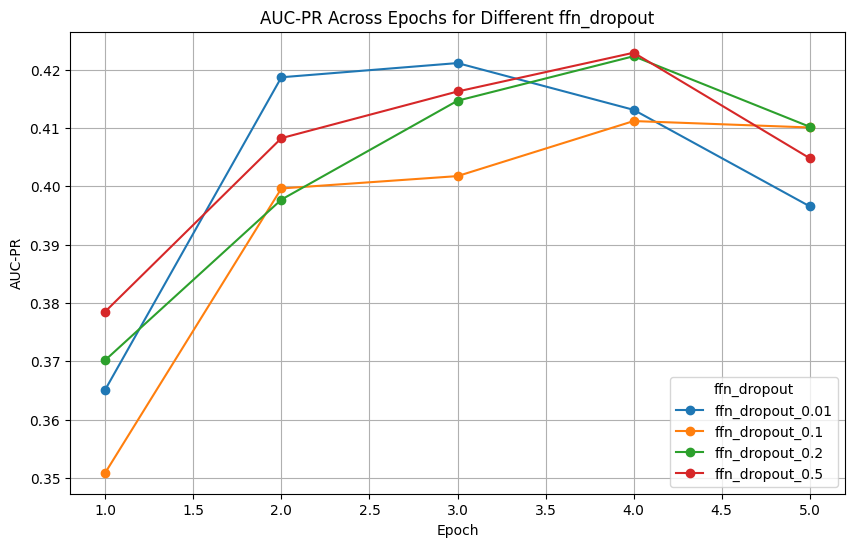

In [53]:
def test_ffn_dropout_rates():
    auc_pr_history={}
    dropout_rates = [0.01, 0.1, 0.2,0.5]

    for rate in dropout_rates:
        gct_params = {
            "embedding_size": 128,
            "num_transformer_stack": 3,
            "num_feedforward": 2,
            "num_attention_heads": 1,
            "ffn_dropout": rate,
            "attention_normalizer": "softmax",
            "multihead_attention_aggregation": "concat",
            "directed_attention": False,
            "use_inf_mask": True,
            "use_prior": True,
            "lr":0.001
        }
        model = GraphConvolutionalTransformer(**gct_params)
        transformer = EHRTransformer(gct_params=gct_params)

        values = transformer.train_and_val(model,train_loader=train_dataloader, val_loader=validate_dataloader,train_df=train_df,val_df=validate_df, n_epochs=5)
        auc_pr_history[str(rate)]=values

    return auc_pr_history

auc_pr_history = test_ffn_dropout_rates()

plot_AUC_PR(auc_pr_history,"ffn_dropout")


Epoch: 1 	 Step: 100 Training Loss: 1.647264
Epoch: 1 	 Step: 200 Training Loss: 1.647760
Epoch: 1 	 Step: 300 Training Loss: 1.639206
Epoch: 1 	 Step: 400 Training Loss: 1.639019
Epoch: 1 	 Step: 500 Training Loss: 1.636149
Epoch: 1 	 Step: 600 Training Loss: 1.633240
Epoch: 1 	 Step: 700 Training Loss: 1.629728
Epoch: 1 	 Step: 800 Training Loss: 1.626776
Epoch: 1 	 Step: 900 Training Loss: 1.624601
Epoch: 1 	 Step: 1000 Training Loss: 1.622506
Epoch: 1 	 Validation AUC_PR: 0.34
Epoch: 2 	 Step: 100 Training Loss: 1.577381
Epoch: 2 	 Step: 200 Training Loss: 1.594691
Epoch: 2 	 Step: 300 Training Loss: 1.597283
Epoch: 2 	 Step: 400 Training Loss: 1.599286
Epoch: 2 	 Step: 500 Training Loss: 1.598441
Epoch: 2 	 Step: 600 Training Loss: 1.596848
Epoch: 2 	 Step: 700 Training Loss: 1.597274
Epoch: 2 	 Step: 800 Training Loss: 1.596483
Epoch: 2 	 Step: 900 Training Loss: 1.598012
Epoch: 2 	 Step: 1000 Training Loss: 1.598507
Epoch: 2 	 Validation AUC_PR: 0.37
Epoch: 3 	 Step: 100 Trainin

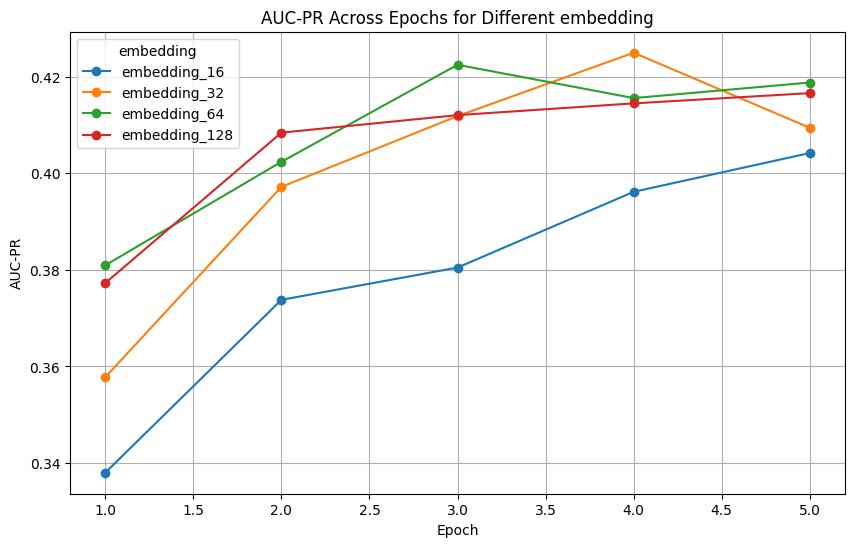

In [56]:
def test_embedding_size():
    auc_pr_history={}
    embedding_size = [16, 32, 64,128]

    for size in embedding_size:
        gct_params = {
            "embedding_size": size,
            "num_transformer_stack": 3,
            "num_feedforward": 2,
            "num_attention_heads": 1,
            "ffn_dropout": 0.01,
            "attention_normalizer": "softmax",
            "multihead_attention_aggregation": "concat",
            "directed_attention": False,
            "use_inf_mask": True,
            "use_prior": True,
            "lr":0.001
        }
        model = GraphConvolutionalTransformer(**gct_params)
        transformer = EHRTransformer(gct_params=gct_params)

        values = transformer.train_and_val(model,train_loader=train_dataloader, val_loader=validate_dataloader,train_df=train_df,val_df=validate_df, n_epochs=5)
        auc_pr_history[str(size)]=values

    return auc_pr_history

auc_pr_history = test_embedding_size()

plot_AUC_PR(auc_pr_history,"embedding")

Epoch: 1 	 Step: 100 Training Loss: 1.721334
Epoch: 1 	 Step: 200 Training Loss: 1.685307
Epoch: 1 	 Step: 300 Training Loss: 1.672036
Epoch: 1 	 Step: 400 Training Loss: 1.663872
Epoch: 1 	 Step: 500 Training Loss: 1.656829
Epoch: 1 	 Step: 600 Training Loss: 1.654970
Epoch: 1 	 Step: 700 Training Loss: 1.652667
Epoch: 1 	 Step: 800 Training Loss: 1.649471
Epoch: 1 	 Step: 900 Training Loss: 1.646809
Epoch: 1 	 Step: 1000 Training Loss: 1.641557
Epoch: 1 	 Validation AUC_PR: 0.33
Epoch: 2 	 Step: 100 Training Loss: 1.592819
Epoch: 2 	 Step: 200 Training Loss: 1.598757
Epoch: 2 	 Step: 300 Training Loss: 1.600225
Epoch: 2 	 Step: 400 Training Loss: 1.602157
Epoch: 2 	 Step: 500 Training Loss: 1.604401
Epoch: 2 	 Step: 600 Training Loss: 1.606220
Epoch: 2 	 Step: 700 Training Loss: 1.606705
Epoch: 2 	 Step: 800 Training Loss: 1.609506
Epoch: 2 	 Step: 900 Training Loss: 1.610863
Epoch: 2 	 Step: 1000 Training Loss: 1.610094
Epoch: 2 	 Validation AUC_PR: 0.35
Epoch: 3 	 Step: 100 Trainin

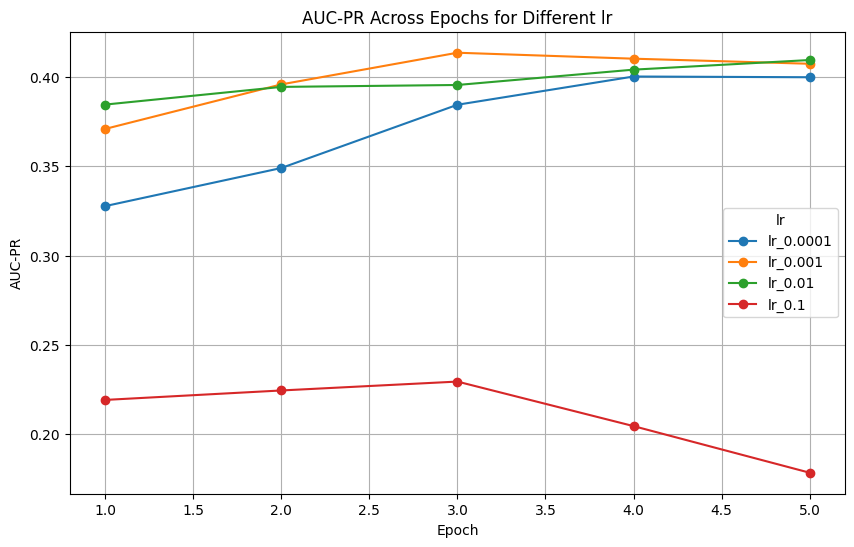

In [57]:
def test_learning_rate():
    auc_pr_history={}
    lrs = [0.0001,0.001,0.01,0.1]

    for lr in lrs:
        gct_params = {
            "embedding_size": 128,
            "num_transformer_stack": 3,
            "num_feedforward": 2,
            "num_attention_heads": 1,
            "ffn_dropout": 0.01,
            "attention_normalizer": "softmax",
            "multihead_attention_aggregation": "concat",
            "directed_attention": False,
            "use_inf_mask": True,
            "use_prior": True,
            "lr":lr
        }
        model = GraphConvolutionalTransformer(**gct_params)
        transformer = EHRTransformer(gct_params=gct_params)

        values = transformer.train_and_val(model,train_loader=train_dataloader, val_loader=validate_dataloader,train_df=train_df,val_df=validate_df, n_epochs=5)
        auc_pr_history[str(lr)]=values

    return auc_pr_history

auc_pr_history = test_learning_rate()

plot_AUC_PR(auc_pr_history,"lr")

### Computational requirements
#### Report at least 3 types of requirements such as type of hardware, average runtime for each epoch, total number of trials, GPU hrs used,
- Hardware: colab CPU
- Average runtime per epoch: 4m50s
- trials:30 epochs

### Training code

- best parameters are {'droprate':0.1, 'lr':0.001,'embedding_dim':128}

In [60]:
# hepler funtion to test and split

gct_params = {
      "embedding_size": 128,
      "num_transformer_stack": 3,
      "num_feedforward": 2,
      "num_attention_heads": 1,
      "ffn_dropout": 0.1,
      "attention_normalizer": "softmax",
      "multihead_attention_aggregation": "concat",
      "directed_attention": False,
      "use_inf_mask": True,
      "use_prior": True,
      "lr":0.0001
  }
model = GraphConvolutionalTransformer(**gct_params)
transformer = EHRTransformer(gct_params=gct_params)

transformer.train_and_val(model,train_loader=train_dataloader, val_loader=validate_dataloader,train_df=train_df,val_df=validate_df, n_epochs=5)

Epoch: 1 	 Step: 100 Training Loss: 1.627589
Epoch: 1 	 Step: 200 Training Loss: 1.639133
Epoch: 1 	 Step: 300 Training Loss: 1.632226
Epoch: 1 	 Step: 400 Training Loss: 1.627298
Epoch: 1 	 Step: 500 Training Loss: 1.630651
Epoch: 1 	 Step: 600 Training Loss: 1.630009
Epoch: 1 	 Step: 700 Training Loss: 1.631293
Epoch: 1 	 Step: 800 Training Loss: 1.630656
Epoch: 1 	 Step: 900 Training Loss: 1.629003
Epoch: 1 	 Step: 1000 Training Loss: 1.628991
Epoch: 1 	 Validation AUC_PR: 0.36
Epoch: 2 	 Step: 100 Training Loss: 1.598355
Epoch: 2 	 Step: 200 Training Loss: 1.604076
Epoch: 2 	 Step: 300 Training Loss: 1.605354
Epoch: 2 	 Step: 400 Training Loss: 1.602199
Epoch: 2 	 Step: 500 Training Loss: 1.604844
Epoch: 2 	 Step: 600 Training Loss: 1.606469
Epoch: 2 	 Step: 700 Training Loss: 1.605503
Epoch: 2 	 Step: 800 Training Loss: 1.604027
Epoch: 2 	 Step: 900 Training Loss: 1.602975
Epoch: 2 	 Step: 1000 Training Loss: 1.602953
Epoch: 2 	 Validation AUC_PR: 0.37
Epoch: 3 	 Step: 100 Trainin

[0.3592529275372732,
 0.37411525877802115,
 0.38802388591875653,
 0.38937967695142806,
 0.3947565923202996]

## Evaluation
### Metrics descriptions
- AUC-ROC
### Evaluation code
- transformer.eval_model(model, test_loader, test_df)

In [61]:
gct_params = {
      "embedding_size": 128,
      "num_transformer_stack": 3,
      "num_feedforward": 2,
      "num_attention_heads": 1,
      "ffn_dropout": 0.1,
      "attention_normalizer": "softmax",
      "multihead_attention_aggregation": "concat",
      "directed_attention": False,
      "use_inf_mask": True,
      "use_prior": True,
      "lr":0.001
  }
transformer = EHRTransformer(gct_params=gct_params)
transformer.eval_model(model, test_dataloader, test_df)

0.38539847488326173

# Results (15)
## Table of results
- Readdmission tasks

| Metric     | Original Paper | Reproduced Results(test) |Reproduced Results(val)|
|------------|----------------|-------------------------|-----------------|
| AUC-ROC    | 0.5244          | 0.3854               |0.3947


### All claims should be supported by experiment results
- The result is not very closely align with those reported in the original paper.

### Discuss with respect to the hypothesis and results from the original paper
- The hypothesis that GCT can learn the hidden structure of EHR data was uncertain.

### Experiments beyond the original paper

 #### Each experiment should include results and a discussion
* Runing time experiment
    - The code in the original code base takes 153 second for 100 steps, which is equals to 12hr for each epoch in my cpu. However, the colab cup only needs 5 mins for each epoch.
    - The time saving comes from the panda dataframe. Input as dataframes are saved in memory, while the original code needs to get the tfrecord input from the disk each batch.

### Ablation Study.
- Impact of varying dropout rates,learning rate, hidden dims on model performance.

# Discussion (10)
## Implications of the experimental results, whether the original paper was reproducible, and if it wasn’t, what factors made it irreproducible

- The original paper demonstrates high reproducibility, with the final AUC-PR in some degree matching that of the original findings for the task of readmission.
## What was easy
- Transitioning from TensorFlow records to pytorch dataframes streamlined the workflow and enhanced accessibility.

## What was difficult
- Bug detection proved time-consuming, exemplified by the discovery that tf.float32.max does not equate to float('inf'), but rather to torch.finfo(torch.float32).max. This discrepancy required extensive debugging and the development of numerous helper functions.
- The default value of `float('inf')` in `inf_mask` led to the generation of numerous `NaNs` and compromised the `pre_softmax` within `qk_op` function.

## Recommendations to the original authors or others who work in this area for improving reproducibility
- The orignial paper gives 41026 piece of eicu data as input, while in the dataframe, it only gives 40410. The missing piece of data is because of the joining method. It will be better to write code to detect them for future student to reporduce this paper
- Other tasks, such as the synthesis of data and other prediction tasks like motility, were not reproduced within this study due to time constraints. Encouraging others to replicate these aspects using the provided codebase could enrich the scientific discourse and validate the findings further

- The code is not supporting GPU yet. The difficulties comes from the pandas dataframe column `prior_value`. This is a a list type and comes with variable length. Because of the time limit and easy to train in a CPU, I haven't spend time on that.

# Public GitHub Repo (5)
## Publish your code in a public repository on GitHub and attach the URL in the notebook.
- `[GitHub Repo URL](https://github.com/Alexuiuc/paperReplicateForDHL`
## Make sure your code is documented properly.
## A README.md file describing the exact steps to run your code is required.
- Include comprehensive instructions on setting up the environment, running preprocessing, training, and evaluation scripts.

### video link : https://youtu.be/wIKq0NiEgLE